In [68]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from technicals import create_weekly_dataset, cycling_data
from sklearn.metrics import classification_report as CR, ConfusionMatrixDisplay

In [69]:
X, y = create_weekly_dataset(cycling_data)
X = MinMaxScaler().fit_transform(X)
X = X.reshape(-1, 2,168)


In [70]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [71]:
class_names = encoder.classes_
print(f"Klasifikujeme tieto lokality: {class_names}")

Klasifikujeme tieto lokality: ['#1 - Starý Most' '#10 - Dunajská' '#11 - Most Apollo'
 '#12 - Železná studnička' '#13 - Vajanského 1' '#14 - Vajanského 2'
 '#15 - Incheba Einsteinova' '#16 - Trenčianska'
 '#17 - Dunajská/Lazaretská' '#2 - Starý most 2' '#3 - River Park'
 '#4 - Dolnozemská' '#5 - Devínska cesta' '#6 - Vajnorská'
 '#7 - Vajnorská > NTC' '#8 - Most SNP' '#9 - Páričkova'
 'Cyklomost Slobody' 'Devinska Nova Ves' 'Hradza Berg' 'Viedenska']


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [72]:
model = Sequential()
model.add(Input(shape=(2,168)))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))

model.add(Dense(36, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [73]:
hitory = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2567 - loss: 2.4889 - val_accuracy: 0.3680 - val_loss: 2.0585
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4790 - loss: 1.7144 - val_accuracy: 0.5312 - val_loss: 1.5311
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6087 - loss: 1.2943 - val_accuracy: 0.6320 - val_loss: 1.1543
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6829 - loss: 1.0099 - val_accuracy: 0.6944 - val_loss: 0.9214
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7413 - loss: 0.8276 - val_accuracy: 0.7596 - val_loss: 0.7434
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7888 - loss: 0.6848 - val_accuracy: 0.7893 - val_loss: 0.6465
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8169 - loss: 0.5938 - val_accuracy: 0.8309 - val_loss: 0.5685
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8357 - loss: 0.5208 - val_accuracy: 0.8635 - val_loss:

In [74]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nPresnosť na testovacích dátach: {accuracy*100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8480 - loss: 0.4838

Presnosť na testovacích dátach: 84.80%


In [75]:
idx = 0
pred_prob = model.predict(X_test[idx:idx+1])
pred_label = class_names[np.argmax(pred_prob)]
true_label = class_names[np.argmax(y_test[idx])]

print(f"\nTest vzorka č.{idx}:")
print(f"Realita:   {true_label}")
print(f"Predikcia: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step

Test vzorka č.0:
Realita:   #2 - Starý most 2
Predikcia: #2 - Starý most 2


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


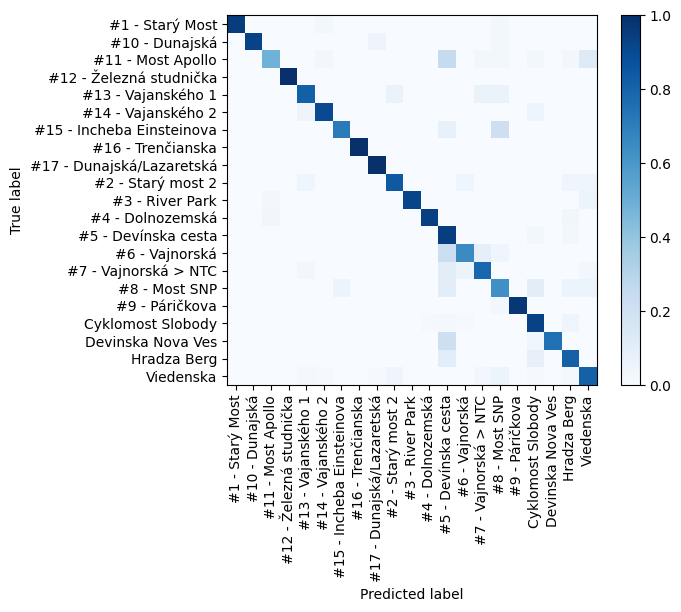

In [76]:
ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(model.predict(X_test), axis=1),
    display_labels=class_names,
    cmap='Blues',
    xticks_rotation='vertical',
    normalize='true',
    include_values=False
)

In [67]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
errors = np.where(y_pred_classes != y_true_classes)[0]
for i in errors[5:10]:
    true_label = class_names[y_true_classes[i]]
    pred_label = class_names[y_pred_classes[i]]
    confidence = np.max(y_pred_probs[i])
    second_best_confidence = np.partition(y_pred_probs[i], -2)[-2]
    second_pred_label = class_names[np.argsort(y_pred_probs[i])[-2]]
    third_best_confidence = np.partition(y_pred_probs[i], -3)[-3]
    third_pred_label = class_names[np.argsort(y_pred_probs[i])[-3]]
    
    print(f"Index {i}: Realita='{true_label}' vs Predikcia='{pred_label}' (Istota: {confidence:.2f})")
    print(f"         Druhá najpravdepodobnejšia predikcia: '{second_pred_label}' (Istota: {second_best_confidence:.2f})")
    print(f"         Tretia najpravdepodobnejšia predikcia: '{third_pred_label}' (Istota: {third_best_confidence:.2f})\n")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Index 35: Realita='#6 - Vajnorská' vs Predikcia='#11 - Most Apollo' (Istota: 0.25)
         Druhá najpravdepodobnejšia predikcia: 'Devinska Nova Ves' (Istota: 0.18)
         Tretia najpravdepodobnejšia predikcia: '#6 - Vajnorská' (Istota: 0.15)

Index 38: Realita='Viedenska' vs Predikcia='#2 - Starý most 2' (Istota: 0.90)
         Druhá najpravdepodobnejšia predikcia: '#13 - Vajanského 1' (Istota: 0.04)
         Tretia najpravdepodobnejšia predikcia: '#6 - Vajnorská' (Istota: 0.03)

Index 48: Realita='#15 - Incheba Einsteinova' vs Predikcia='#8 - Most SNP' (Istota: 0.72)
         Druhá najpravdepodobnejšia predikcia: '#15 - Incheba Einsteinova' (Istota: 0.24)
         Tretia najpravdepodobnejšia predikcia: '#3 - River Park' (Istota: 0.02)

Index 49: Realita='#11 - Most Apollo' vs Predikcia='#8 - Most SNP' (Istota: 0.87)
         Druhá najpravdepodobnejšia predikcia: '#11 - Most Apollo' (Istota: 0.07)
         Tretia najpravdepodobnejšia predikcia: